In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [5]:
!pip install biosppy

     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 40kB 6.5MB/s 
  Created wheel for shortuuid: filename=shortuuid-0.5.0-cp36-none-any.whl size=5499 sha256=e832647ec49adf49f573a33bab77a2d5b3bb76c6bf4d97fe40c9eae2219d47ee
  Stored in directory: /root/.cache/pip/wheels/3f/eb/fd/69e5177f67b505e44acbd1aedfbe44b91768ee0c4cd5636576
Successfully built shortuuid


In [2]:
!pip install --upgrade tqdm

     |████████████████████████████████| 61kB 4.6MB/s 
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.7 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tq
from biosppy.signals import ecg
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter

In [0]:
sample=pd.read_csv("/content/drive/My Drive/task3/sample.csv")

In [8]:
train_signals = []
for x in tq(open('/content/drive/My Drive/task3/X_train.csv')):
    if x.startswith('id'): #header
        continue
    train_signals.append(list(map(int,x.strip().split(',')[1:])))

In [56]:
test_signals = []
for x in tq(open('/content/drive/My Drive/task3/X_test.csv')):
    if x.startswith('id'): #header
        continue
    test_signals.append(list(map(int,x.strip().split(',')[1:])))

In [0]:
train_labels = np.array(pd.read_csv('/content/drive/My Drive/task3/y_train.csv')['y'])

In [0]:
ecg_outs = []

In [12]:
for signal in tq(train_signals):
    out = ecg.ecg(signal=signal,sampling_rate=300,show=False)
    ecg_outs.append(out)

In [0]:
from biosppy.signals import tools


In [0]:
def unfold_data(index):
    X_data = []
    X_label = []
    for i in index:
        h = []
        for t in ecg_outs[i]['templates']:
            h.append(t)
        X_data.append(np.mean(h,axis=0))
        X_label.append(train_labels[i])
    return np.array(X_data).reshape(len(X_data),180,1), np.array(X_label)
    # return np.array(X_data), np.array(X_label)


MAX_DIM = 17813

def process_signal(sig):
  filtered, _, _ = tools.filter_signal(signal=sig,
                                  ftype='FIR',
                                  band='bandpass',
                                  order=90,
                                  frequency=[3, 45],
                                  sampling_rate=300)
  return tools.normalize(filtered)[0]

def unfold_data2(index):
    X_data = []
    X_label = []
    for i in tq(index):
        signal = process_signal(train_signals[i])
        # signal = np.array(train_signals[i])
        rem = MAX_DIM - signal.shape[0]
        if rem:
          signal = np.hstack((signal,np.zeros((rem,))))
        X_data.append(signal.reshape((MAX_DIM,1)))
        X_label.append(train_labels[i])
    return np.array(X_data), np.array(X_label)

def class_weights(y):
    c = Counter(y)
    w = []
    for i in range(4):
        w.append(1/c[i])
    w = np.array(w)
    w = w/np.sum(w)
    return w

In [95]:
X_submit = []
for sig in tq(test_signals):
    signal = process_signal(sig)
    # signal = np.array(sig)
    rem = MAX_DIM - signal.shape[0]
    if rem:
      signal = np.hstack((signal,np.zeros((rem,))))
    X_submit.append(signal.reshape((MAX_DIM,1)))
X_submit = np.array(X_submit)

CONV model

In [0]:
def get_model():
  # model = tf.keras.Sequential([
  #     tf.keras.layers.Conv1D(32,10,2,activation="relu"),
  #     tf.keras.layers.Conv1D(32,10,1,activation="relu"),
  #     tf.keras.layers.MaxPooling1D(3),
  #     tf.keras.layers.Dropout(rate=0.3),
  #     tf.keras.layers.Conv1D(64,10,2,activation="relu"),
  #     tf.keras.layers.Conv1D(64,10,1,activation="relu"),
  #     tf.keras.layers.MaxPooling1D(2),
  #     tf.keras.layers.Dropout(rate=0.3),
  #     tf.keras.layers.Conv1D(128,10,2,activation="relu"),
  #     tf.keras.layers.MaxPooling1D(2),
  #     tf.keras.layers.Dropout(rate=0.3),
  #     tf.keras.layers.Conv1D(256,10,2,activation="relu"),
  #     tf.keras.layers.GlobalMaxPooling1D(),
  #     tf.keras.layers.Dense(256,activation="relu"),
  #     tf.keras.layers.Dense(30,activation="relu"),
  #     tf.keras.layers.Dense(4,activation="softmax")
      
  # ])
  model2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32,10,1,activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv1D(64,10,1,activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv1D(128,10,1,activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv1D(256,10,1,activation="relu"),
    tf.keras.layers.Conv1D(256,10,2,activation="relu"),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv1D(512,10,1,activation="relu"),
    tf.keras.layers.Conv1D(512,10,2,activation="relu"),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(30,activation="relu"),
    tf.keras.layers.Dense(4,activation="softmax")
    
  ])
  return model2

In [0]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):

  def __init__(self,X_train,y_train,X_test,y_test, *args,**kwargs):
    super().__init__(*args,**kwargs)
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test

  def on_train_begin(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
    self.train_f1s = []
    self.train_recalls = []
    self.train_precisions = []
  
  def on_epoch_end(self, epoch, logs={}):
    val_predict = np.asarray(self.model.predict_classes(self.X_test))
    val_targ = self.y_test
    _val_f1 = f1_score(val_targ, val_predict,average='micro')
    _val_recall = recall_score(val_targ, val_predict,average='micro')
    _val_precision = precision_score(val_targ, val_predict,average='micro')
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))

    train_predict = np.asarray(self.model.predict_classes(self.X_train))
    train_targ = self.y_train
    _train_f1 = f1_score(train_targ, train_predict,average='micro')
    _train_recall = recall_score(train_targ, train_predict,average='micro')
    _train_precision = precision_score(train_targ, train_predict,average='micro')
    self.train_f1s.append(_train_f1)
    self.train_recalls.append(_train_recall)
    self.train_precisions.append(_train_precision)
    return


In [0]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(list(range(len(train_labels))), test_size=0.1,shuffle=True, random_state=42,stratify=train_labels)

In [0]:
def predict(index, preds): # for majority stuff
  num = 0
  result = []
  for i in index:
    ecg_preds = []
    for t in ecg_outs[i]['templates']:
        ecg_preds.append(preds[num])
        num+=1
    result.append(Counter(ecg_preds).most_common(1)[0][0])
  return np.array(result)

In [0]:
from tensorflow.keras.optimizers import Adam
X_train, y_train = unfold_data2(train_index)
X_test, y_test = unfold_data2(test_index)
metrics = Metrics(X_train, y_train, X_test,y_test)
model = get_model()
model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=["sparse_categorical_accuracy"],weights=class_weights(y_train))
history = model.fit(X_train,y_train, validation_data = (X_test, y_test), batch_size=10,epochs=30,callbacks=[metrics],shuffle=True)


Train on 4605 samples, validate on 512 samples
Epoch 1/30
4605/4605 [==============================] - 49s 11ms/sample - loss: 1.0376 - sparse_categorical_accuracy: 0.5876 - val_loss: 0.9734 - val_sparse_categorical_accuracy: 0.5918
Epoch 2/30
4605/4605 [==============================] - 45s 10ms/sample - loss: 0.8954 - sparse_categorical_accuracy: 0.6276 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.6836
Epoch 3/30
4605/4605 [==============================] - 45s 10ms/sample - loss: 0.7151 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.7166 - val_sparse_categorical_accuracy: 0.7148
Epoch 4/30
4605/4605 [==============================] - 45s 10ms/sample - loss: 0.6478 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.7516 - val_sparse_categorical_accuracy: 0.7031
Epoch 5/30
4605/4605 [==============================] - 45s 10ms/sample - loss: 0.6050 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.5888 - val_sparse_categorical_accuracy: 0.7656
Epoch 6/30
4605/4605 [

In [114]:
print('Last 5 epochs f1 mean', np.mean(metrics.val_f1s[20:25]))
print('Last 5 epochs f1 std', np.std(metrics.val_f1s[20:25]))

Last 5 epochs f1 mean 0.81015625
Last 5 epochs f1 std 0.010290578025249601


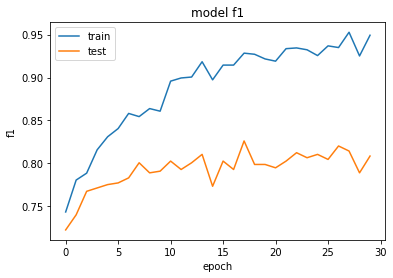

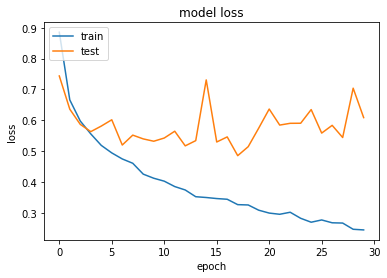

In [102]:
import matplotlib.pyplot as plt


plt.plot(metrics.train_f1s)
plt.plot(metrics.val_f1s)
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

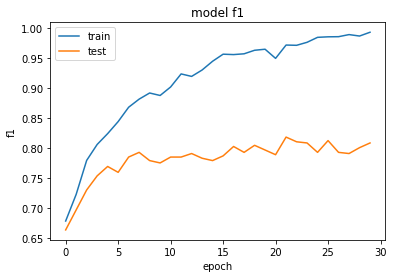

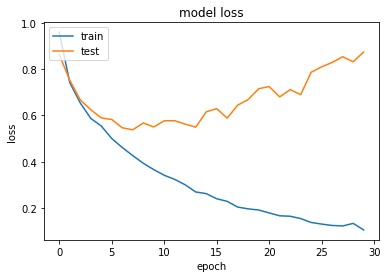

In [51]:
import matplotlib.pyplot as plt


plt.plot(metrics.train_f1s)
plt.plot(metrics.val_f1s)
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model.fit(X_train,y_train, validation_data = (X_test, y_test), batch_size=10,epochs=30,callbacks=[metrics],shuffle=True)

Train on 4605 samples, validate on 512 samples
Epoch 1/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1912 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.7732 - val_sparse_categorical_accuracy: 0.7930
Epoch 2/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1956 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.8066
Epoch 3/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1718 - sparse_categorical_accuracy: 0.9398 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.8184
Epoch 4/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1605 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.8023 - val_sparse_categorical_accuracy: 0.8027
Epoch 5/30
4605/4605 [==============================] - 6s 1ms/sample - loss: 0.1694 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.8008
Epoch 6/30
4605/4605 [===========

In [104]:
model = get_model()
X_train, y_train = unfold_data2(list(range(len(train_signals))))
model.compile(optimizer=Adam(learning_rate=0.001),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=["sparse_categorical_accuracy"],weights=class_weights(y_train))
model.fit(X_train,y_train, batch_size=10,epochs=30,shuffle=True)


Train on 5117 samples
Epoch 1/30
5117/5117 [==============================] - 7s 1ms/sample - loss: 0.8931 - sparse_categorical_accuracy: 0.6277
Epoch 2/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.6836 - sparse_categorical_accuracy: 0.7254
Epoch 3/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.5944 - sparse_categorical_accuracy: 0.7676
Epoch 4/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.5435 - sparse_categorical_accuracy: 0.7837
Epoch 5/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.5118 - sparse_categorical_accuracy: 0.8042
Epoch 6/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.4739 - sparse_categorical_accuracy: 0.8216
Epoch 7/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.4510 - sparse_categorical_accuracy: 0.8313
Epoch 8/30
5117/5117 [==============================] - 6s 1ms/sample - loss: 0.4243 - sparse_categorical_accuracy: 

In [0]:
y_pred = model.predict_classes(X_submit)

In [0]:
sample['y']=y_pred

In [0]:
sample.to_csv("/content/drive/My Drive/task3/correct_filtered_normalized_sub.csv",index=False)

In [0]:
submission(y_pred,sample,"/content/drive/My Drive/Third year/Advanced Machine Learning/task3/conv-60epochs.csv")

   id  y
0   0  0
1   1  0
2   2  0
3   3  0
4   4  0


In [0]:
model.fit(X_train_copy,y_train_copy.flatten(),batch_size=10,epochs=30)

Train on 5117 samples
Epoch 1/30
Train on 5117 samples
Epoch 1/30
5117/5117 [==============================] - 285s 56ms/sample - loss: 0.4195 - sparse_categorical_accuracy: 0.8614
Epoch 2/30
Epoch 2/30
5117/5117 [==============================] - 285s 56ms/sample - loss: 0.3626 - sparse_categorical_accuracy: 0.8720
Epoch 3/30
Epoch 3/30
5117/5117 [==============================] - 284s 56ms/sample - loss: 0.3926 - sparse_categorical_accuracy: 0.8640
Epoch 4/30
Epoch 4/30
5117/5117 [==============================] - 284s 56ms/sample - loss: 0.3744 - sparse_categorical_accuracy: 0.8726
Epoch 5/30
Epoch 5/30
5117/5117 [==============================] - 282s 55ms/sample - loss: 0.3760 - sparse_categorical_accuracy: 0.8657
Epoch 6/30
Epoch 6/30
5117/5117 [==============================] - 284s 56ms/sample - loss: 0.3680 - sparse_categorical_accuracy: 0.8706
Epoch 7/30
Epoch 7/30
5117/5117 [==============================] - 282s 55ms/sample - loss: 0.3630 - sparse_categorical_accuracy: 0.87

In [0]:
y_pred_logits=model.predict(X_test_copy)
y_pred=np.argmax(y_pred_logits,axis=1)


In [0]:
submission(y_pred,sample,"/content/drive/My Drive/Third year/Advanced Machine Learning/task3/conv-90epochs.csv")

In [0]:
test2=pd.read_csv("/content/test2.csv")
conv_60=pd.read_csv("/content/conv-60epochs.csv")
conv_90=pd.read_csv("/content/conv-90epochs.csv")

In [0]:
conv_60.head()

,Unnamed: 0,id,y
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,0


In [0]:
test2=test2.iloc[:,2]

In [0]:
conv_60=conv_60.iloc[:,2]
conv_90=conv_90.iloc[:,2]

In [0]:
all_submissions=pd.concat([test2,conv_60,conv_90],axis=1)

In [0]:
all_submissions.shape

(3411, 3)

In [0]:
all_submissions=all_submissions.to_numpy()

In [0]:
majority=[]
for row in all_submissions:
  majority.append(np.bincount(row).argmax())

In [0]:
majority=np.array(majority)

In [0]:
majority.shape

(3411,)

In [0]:
submission(majority,sample,"average.csv")

   id  y
0   0  0
1   1  0
2   2  0
3   3  0
4   4  0
